# WeatherPy

---

## Starter Code to Generate Random Geographic Coordinates and a List of Cities

In [44]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st


# Impor the OpenWeatherMap API key
from api_keys import weather_api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

In [45]:
#POINT_COUNT = 1500
POINT_COUNT = 50

# Set the API base URL
BASE_URL = "https://api.openweathermap.org/data/2.5/weather"

HTTP_STATUS_NOT_FOUND = 404

HTTP_STATUS_OK = 200

### Generate the Cities List by Using the `citipy` Library

In [46]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=POINT_COUNT)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=POINT_COUNT)
lat_lngs = zip(lats, lngs)


In [47]:
# Empty list for holding the cities names
cities = []

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 43


---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the started code

In [48]:
#define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0
        # Log the url, record, and set numbers
        print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Create endpoint URL with each city
    city_url = f"{BASE_URL}?appid={weather_api_key}&units=metric&q={city.replace(' ', '+')}"
    
    # Add 1 to the record count
    record_count += 1

    # Run an API request for each of the cities
    response = requests.get(city_url)
    if response.status_code == HTTP_STATUS_NOT_FOUND:
        print("City not found. Skipping...")
    elif response.status_code == HTTP_STATUS_OK:
        try: 
            # Parse the JSON 
            city_weather = response.json()
            # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
            city_lat = city_weather['coord']['lat']
            city_lng = city_weather['coord']['lon']
            city_max_temp = city_weather['main']['temp_max']
            city_humidity = city_weather['main']['humidity']
            city_clouds = city_weather['clouds']['all']
            city_wind = city_weather['wind']['speed']
            city_country = city_weather['sys']['country']
            city_date = city_weather['dt']

             # Append the City information into city_data list
            city_data.append({"City": city, 
                               "Lat": city_lat, 
                               "Lng": city_lng, 
                               "Max Temp": city_max_temp,
                               "Humidity": city_humidity,
                               "Cloudiness": city_clouds,
                               "Wind Speed": city_wind,
                               "Country": city_country,
                               "Date": city_date,
                              })
            

    # If an error is experienced, skip the city
        except KeyError as e:
            raise e
    else: 
        raise ValueError(f"Unknown Status Code: {response.status_code} for city {city}")
        
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
City not found. Skipping...
City not found. Skipping...
-----------------------------
Data Retrieval Complete      
-----------------------------


In [49]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame(city_data)

# Convert the date
city_data_df['Date'] = pd.to_datetime(city_data_df['Date'], unit='s').dt.date

# Show Record Count
city_data_df.count()

City          41
Lat           41
Lng           41
Max Temp      41
Humidity      41
Cloudiness    41
Wind Speed    41
Country       41
Date          41
dtype: int64

In [50]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,papao,-17.7500,-149.5500,24.82,72,21,6.74,PF,2023-06-06
1,bredasdorp,-34.5322,20.0403,10.11,72,36,0.93,ZA,2023-06-06
2,iqaluit,63.7506,-68.5145,6.85,70,40,5.66,CA,2023-06-06
3,edinburgh of the seven seas,-37.0676,-12.3116,12.50,66,100,7.46,SH,2023-06-06
4,talnakh,69.4865,88.3972,6.23,86,36,3.05,RU,2023-06-06


In [51]:
# Export the City_Data into a csv
city_data_df.to_csv("output_data/cities.csv", index_label="City_ID")

In [52]:
# Read saved data
city_data_df = pd.read_csv("output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,papao,-17.7500,-149.5500,24.82,72,21,6.74,PF,2023-06-06
1,bredasdorp,-34.5322,20.0403,10.11,72,36,0.93,ZA,2023-06-06
2,iqaluit,63.7506,-68.5145,6.85,70,40,5.66,CA,2023-06-06
3,edinburgh of the seven seas,-37.0676,-12.3116,12.50,66,100,7.46,SH,2023-06-06
4,talnakh,69.4865,88.3972,6.23,86,36,3.05,RU,2023-06-06


### Create the Scatter Plots Requested

#### Latitude Vs. Temperature

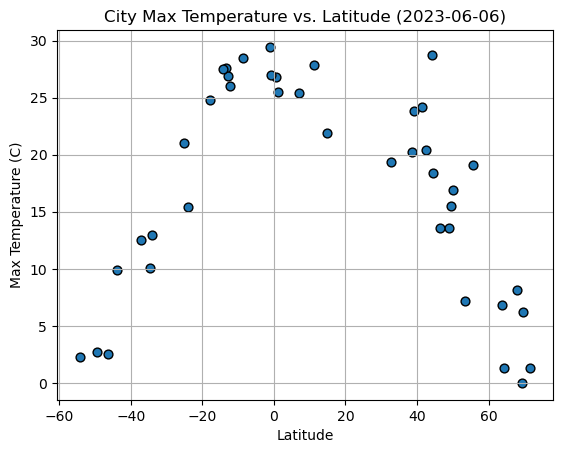

<Figure size 640x480 with 0 Axes>

In [53]:
# Build scatter plot for latitude vs. temperature

date = city_data_df['Date'].max()

city_data_df.plot(kind="scatter", x="Lat", y="Max Temp", xlabel="Latitude",ylabel="Max Temperature (C)",
                  grid=True, edgecolor="black", s=40, title=(f"City Max Temperature vs. Latitude ({date})"))

plt.show()

# Save the figure
plt.savefig("output_data/Fig1.png")



#### Latitude Vs. Humidity

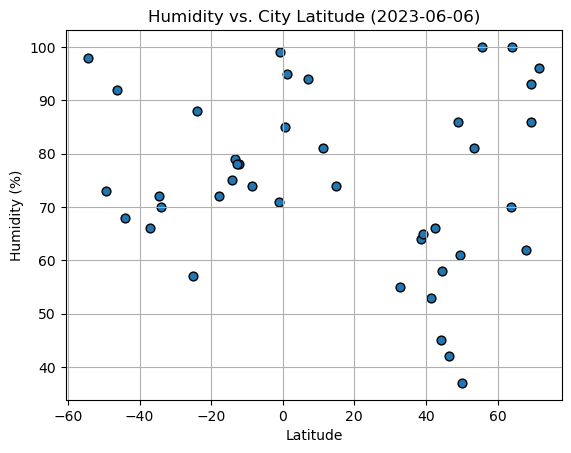

In [54]:
# Build the scatter plots for latitude vs. humidity

city_data_df.plot(kind="scatter", x="Lat", y="Humidity", xlabel="Latitude",ylabel="Humidity (%)",
                  grid=True, edgecolor="black", s=40, title=(f"Humidity vs. City Latitude ({date})"))

# Save the figure
plt.savefig("output_data/Fig2.png")

#show plot
plt.show()


#### Latitude Vs. Cloudiness

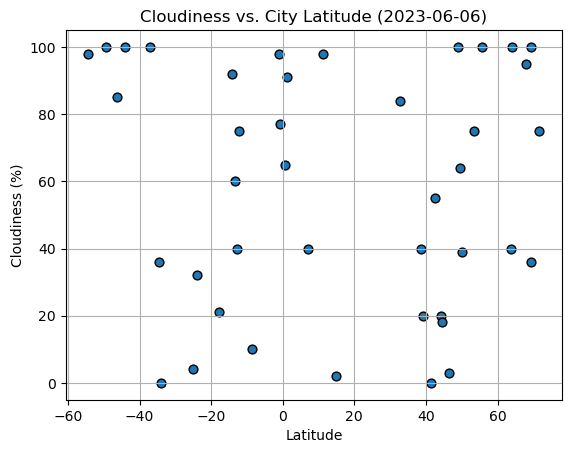

In [55]:
# Build the scatter plots for latitude vs. cloudiness

city_data_df.plot(kind="scatter", x="Lat", y="Cloudiness", xlabel="Latitude",ylabel="Cloudiness (%)",
                  grid=True, edgecolor="black", s=40, title=(f"Cloudiness vs. City Latitude ({date})"))

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

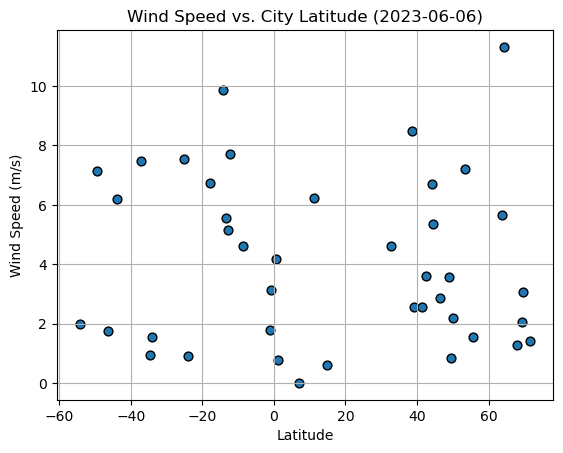

In [56]:
# Build the scatter plots for latitude vs. wind speed

city_data_df.plot(kind="scatter", x="Lat", y="Wind Speed", xlabel="Latitude",ylabel="Wind Speed (m/s)",
                  grid=True, edgecolor="black", s=40, title=(f"Wind Speed vs. City Latitude ({date})"))

# Save the figure
plt.savefig("output_data/Fig4.png")

# Show plot
plt.show()

---

## Requirement 2: Compute Linear Regression for Each Relationship


In [98]:
# Define a function to create Linear Regression plots
def lin_regress_plot(df, xcol, ycol, x_label, y_label, title):
    df.plot(kind="scatter", x=xcol, y=ycol, xlabel=x_label, ylabel=y_label,
                  grid=True, edgecolor="black", s=40, title=title)
    (slope, intercept, rvalue, pvalue, _) = st.linregress(df[xcol], df[ycol])
    y_calc = df[xcol] * slope + intercept
    line_eq = f"y = {round(slope,2)} x + {round(intercept,2)}"
    plt.plot(df[xcol], y_calc, color="red")
    plt.annotate(line_eq, (5, 10), fontsize=15,color="red")
    print(f"The r-value is: {rvalue}")
    plt.show()


The r-value is: -0.08378733295637127


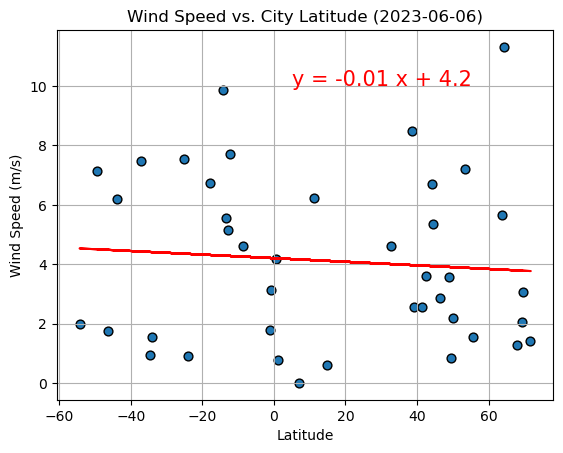

In [102]:
lin_regress_plot(df=city_data_df, ycol="Wind Speed", xcol="Lat", x_label="Latitude", 
                 y_label="Wind Speed (m/s)", title=(f"Wind Speed vs. City Latitude ({date})"))




In [92]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)

northern_hemi_df = city_data_df[city_data_df['Lat']>=0]

# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
2,iqaluit,63.7506,-68.5145,6.85,70,40,5.66,CA,2023-06-06
4,talnakh,69.4865,88.3972,6.23,86,36,3.05,RU,2023-06-06
5,albany,42.6001,-73.9662,20.37,66,55,3.61,US,2023-06-06
6,al qubbah,32.7616,22.2424,19.38,55,84,4.62,LY,2023-06-06
8,ribeira grande,38.5167,-28.7000,20.22,64,40,8.49,PT,2023-06-06


In [33]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df[city_data_df['Lat']<0]

# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
4,margaret river,-33.9500,115.0667,11.20,72,98,8.74,AU,2023-06-06
6,hermanus,-34.4187,19.2345,8.78,61,17,0.99,ZA,2023-06-06
9,ushuaia,-54.8000,-68.3000,5.79,87,75,10.80,AR,2023-06-06
13,carutapera,-1.1950,-46.0200,27.99,85,60,3.01,BR,2023-06-06
16,maintirano,-18.0667,44.0167,24.93,76,0,3.85,MG,2023-06-06


###  Temperature vs. Latitude Linear Regression Plot

The r-value is: 0.7161472181434118


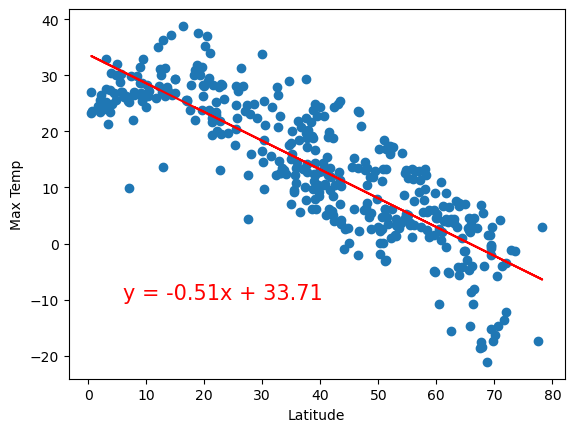

In [15]:
# Linear regression on Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.4121057168607245


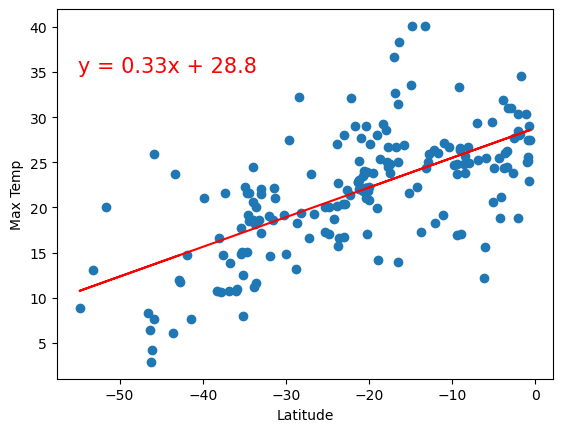

In [16]:
# Linear regression on Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Humidity vs. Latitude Linear Regression Plot

The r-value is: 0.05689741545789598


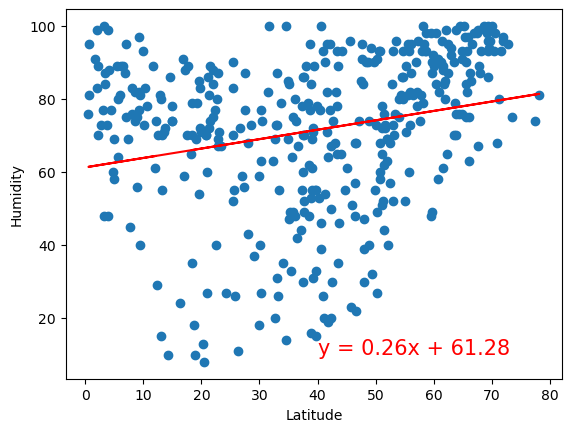

In [17]:
# Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.0002808747046324607


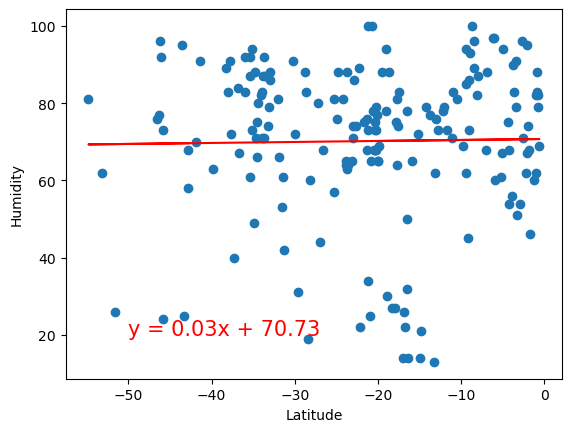

In [18]:
# Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Cloudiness vs. Latitude Linear Regression Plot

The r-value is: 0.024026517125811015


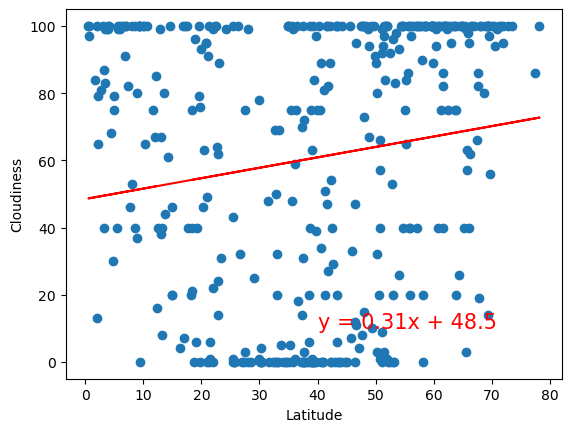

In [19]:
# Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.02056735429994368


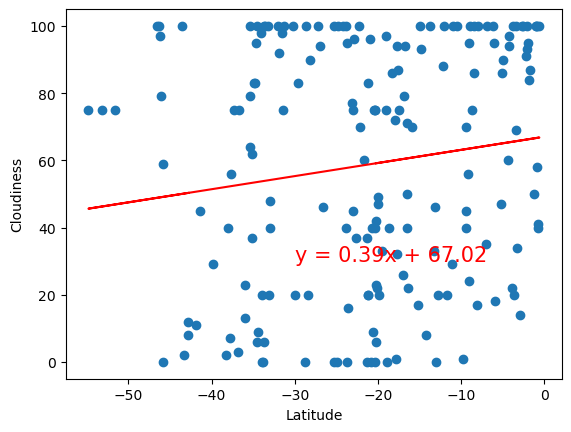

In [20]:
# Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Wind Speed vs. Latitude Linear Regression Plot

The r-value is: 0.030396762354449467


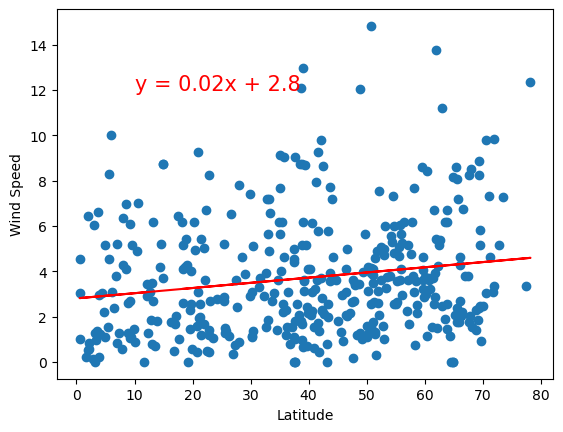

In [21]:
# Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.062239040700515696


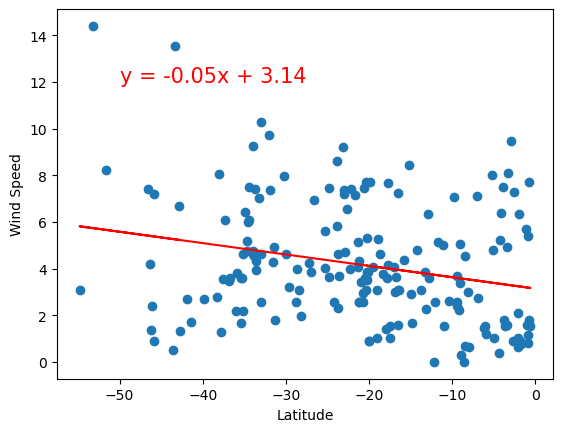

In [22]:
# Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE